In [1]:
folder_name = "Face-Mask-Detection"

In [2]:
import os
try:
    os.chdir(folder_name)
except:
    print("Run only once")

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mlsteam import stparams

# Start Inference

In [4]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(["face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["face_detector", "res10_300x300_ssd_iter_140000.caffemodel"])
print(prototxtPath, weightsPath)
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model(stparams.get_value('weights_file', 'mask_detector.model'))

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread("images/pic1.jpeg")
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] loading face detector model...
face_detector/deploy.prototxt face_detector/res10_300x300_ssd_iter_140000.caffemodel
[INFO] loading face mask detector model...
[INFO] computing face detections...


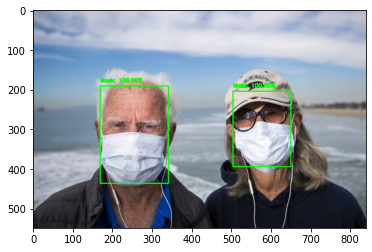

In [5]:
# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]

    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
imgplot = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()